# Feature extraction using VGG16

In [2]:
# import packages - basics 
import pandas as pd
import os
import numpy as np
import cv2
# tf tools
import tensorflow as tf
# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD
#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
# for plotting
import matplotlib.pyplot as plt

2023-05-23 23:41:44.807311: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Plotting function (from last week)

In [3]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Loading in the data

In [4]:
classes=sorted(os.listdir("../data/images/train"))
",".join([f"{i}:{c}" for i,c in enumerate(classes)])
# getting rid of the .DS_store thing that Macs apparently do 
if '.DS_Store' in classes:
    classes.remove('.DS_Store')


In [5]:
# these are all the same so can be done the same below 
train_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2,
                                    preprocessing_function = preprocess_input)


test_generator = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function = preprocess_input)

In [6]:
BATCH_SIZE = 32
TARGET_SIZE = (224,224)

# Split the data into categories
train_images = train_generator.flow_from_directory(
    "../data/images/train",
    classes=classes,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="training",
    seed=42)

# Split the data into categories
val_images = train_generator.flow_from_directory(
    directory="../data/images/train",
    classes=classes,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=42)



test_images = test_generator.flow_from_directory(
    "../data/images/test",
    # names are inconsistent so changing them to all lowercase 
    classes=list(map(lambda x:x.lower().replace("strawberries","stawberries"),classes)),
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
)



Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


## Initialize the model

__Load VGG16 *without* the classification layers__

Here we're just loading the convolutional layers and not the final classification network, using the argument ```include_top=False```



In [7]:
# load the model
model = VGG16()

In [8]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

__Disable training of Conv layers__

We need to disable the convolutional layers before training. Why?

In [9]:
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

Means we're freezing the weights and not retraining the model

In [9]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Add new classification layers__

We now add new classification layers after the convolutional layers.

Notice how here we are not using the ```Sequential```, so we have to explicitly name the preceding layer in the model!

In [10]:
tf.keras.backend.clear_session()

In [11]:
# add new classifier layers - another way of adding layers - different than previous syntax we've seen before 
flat1 = Flatten()(model.layers[-1].output) 
class1 = Dense(128, activation='relu')(flat1) 
output = Dense(len(classes), activation='softmax')(class1) # Change here for how many labels there are - changed to len of classes 

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Can now compare with above and can see we added almost 67,000  trainable parameters 

__Compile__

We're going to be using a more sophisticated optimization algorithm, which you can read about [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay).

In [12]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, 
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

In [13]:
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

__Train__

In [15]:
batch_size = 125
H = model.fit(train_images,
            batch_size=batch_size,
            validation_data=val_images,
            #steps_per_epoch=train_images.samples // batch_size,
            #validation_steps=val_images.samples // batch_size,
            epochs=25,
            verbose=1)

Epoch 1/25


2023-05-23 20:56:03.570934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - ETA: 0s - loss: 2.2233 - accuracy: 0.2042

2023-05-23 20:57:43.341898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - 129s 2s/step - loss: 2.2233 - accuracy: 0.2042 - val_loss: 2.1641 - val_accuracy: 0.2913
Epoch 2/25
58/58 [==============================] - 84s 1s/step - loss: 2.1390 - accuracy: 0.3167 - val_loss: 2.0964 - val_accuracy: 0.3674
Epoch 3/25
58/58 [==============================] - 83s 1s/step - loss: 2.0608 - accuracy: 0.3998 - val_loss: 2.0238 - val_accuracy: 0.4652
Epoch 4/25
58/58 [==============================] - 83s 1s/step - loss: 1.9877 - accuracy: 0.4335 - val_loss: 1.9680 - val_accuracy: 0.3978
Epoch 5/25
58/58 [==============================] - 85s 1s/step - loss: 1.9210 - accuracy: 0.4666 - val_loss: 1.8898 - val_accuracy: 0.4891
Epoch 6/25
58/58 [==============================] - 83s 1s/step - loss: 1.8503 - accuracy: 0.5133 - val_loss: 1.8248 - val_accuracy: 0.5696
Epoch 7/25
58/58 [==============================] - 84s 1s/step - loss: 1.7869 - accuracy: 0.5334 - val_loss: 1.7572 - val_accuracy: 0.5891
Epoch 8/25
58/58 [============

__Evaluate__

/tmp/ipykernel_1331/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


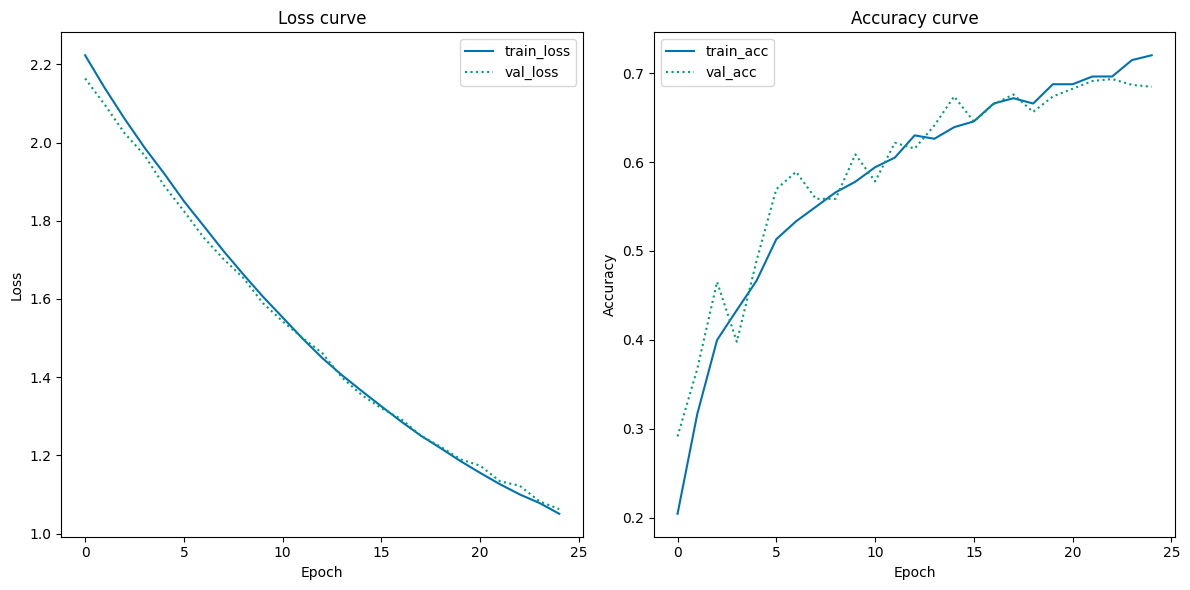

In [16]:
# the number is for the number of epochs 
plot_history(H, 25)

The downward tragectory of the learning curve suggests that it have more to learn. No surprise since it was only a handful of epochs with not a lot of data. 

In [16]:
model.evaluate(test_images)


2023-05-20 00:10:35.156629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 61s 2s/step - loss: 1.1531 - accuracy: 0.6576


[1.1531099081039429, 0.6575610041618347]

So accuracy is 44% in the test set which is 4% less than the validation accuracy during training. 

In [18]:
predictions = model.predict(test_images, batch_size=32)
print(classification_report(test_images.classes,
                            predictions.argmax(axis=1),
                            target_names=classes)) 


2023-05-23 23:39:58.181849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 29s 882ms/step
              precision    recall  f1-score   support

       Apple       0.08      0.07      0.07        89
      Banana       0.14      0.13      0.14       106
     avocado       0.11      0.14      0.13       105
      cherry       0.09      0.10      0.09       105
        kiwi       0.07      0.06      0.06       105
       mango       0.07      0.09      0.08       105
      orange       0.11      0.10      0.11        97
  pinenapple       0.15      0.18      0.16       105
strawberries       0.11      0.10      0.10       103
  watermelon       0.10      0.09      0.09       105

    accuracy                           0.11      1025
   macro avg       0.10      0.10      0.10      1025
weighted avg       0.10      0.11      0.10      1025



Accuracy is pretty terrible. Hoping for better with data augmentation to make dataset bigger. 

## Using data augmentation

__Reload model__

In [10]:
del model
tf.keras.backend.clear_session()

In [11]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
bn = BatchNormalization()(flat1)            ## take the outputs (image embeddings) and normalize them 
class1 = Dense(256,                         ### only difference is adding this extra hidden layer 
               activation='relu')(bn)
class2 = Dense(128, 
               activation='relu')(class1)
output = Dense(len(classes), 
               activation='softmax')(class2)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Define data generator__

You can see the documentation for ImageDataGenerator [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [12]:
# flip along x axis (mirror image)
datagen = ImageDataGenerator(rescale=1./255,
                            validation_split=0.2,
                            horizontal_flip=True, 
                            rotation_range=20, # how many degrees to rotate it 
                            preprocessing_function = preprocess_input)

In [13]:
# these are all the same so can be done the same below 
#train_generator = ImageDataGenerator(rescale=1./255,
#                                    validation_split=0.2)


test_datagen = ImageDataGenerator(rescale=1./255,  
                            horizontal_flip=True, 
                            rotation_range=20, # how many degrees to rotate it 
                            preprocessing_function = preprocess_input)

We're choosing to generate data on the fly, rather than save it to a folder. This validation split labels some as training and some as validation which we use below when training. 

__Train__

In [14]:
BATCH_SIZE = 32
TARGET_SIZE = (224,224)

# Split the data into categories
train_images = datagen.flow_from_directory(
    "../data/images/train",
    classes=classes,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="training",
    seed=42)

# Split the data into categories
val_images = datagen.flow_from_directory(
    directory="../data/images/train",
    classes=classes,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=42)


test_images = test_datagen.flow_from_directory(
    "../data/images/test",
    # names are inconsistent so changing them to all lowercase 
    classes=list(map(lambda x:x.lower().replace("strawberries","stawberries"),classes)),
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
)

Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


In [23]:
batch_size = 64
H = model.fit(train_images,
            batch_size=batch_size,
            validation_data=val_images,
            steps_per_epoch=train_images.samples // batch_size,
            validation_steps=val_images.samples // batch_size,
            epochs=25,
            verbose=1)


Epoch 1/25


2023-05-20 00:15:07.053851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - ETA: 0s - loss: 2.3442 - accuracy: 0.1663

2023-05-20 00:15:35.056944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 35s 1s/step - loss: 2.3442 - accuracy: 0.1663 - val_loss: 2.2980 - val_accuracy: 0.1339
Epoch 2/25
28/28 [==============================] - 33s 1s/step - loss: 1.9732 - accuracy: 0.3564 - val_loss: 2.1938 - val_accuracy: 0.2946
Epoch 3/25
28/28 [==============================] - 33s 1s/step - loss: 1.6723 - accuracy: 0.4972 - val_loss: 2.0938 - val_accuracy: 0.3884
Epoch 4/25
28/28 [==============================] - 34s 1s/step - loss: 1.4630 - accuracy: 0.5759 - val_loss: 2.0367 - val_accuracy: 0.4196
Epoch 5/25
28/28 [==============================] - 34s 1s/step - loss: 1.3409 - accuracy: 0.6194 - val_loss: 1.9206 - val_accuracy: 0.4866
Epoch 6/25
28/28 [==============================] - 33s 1s/step - loss: 1.1794 - accuracy: 0.6742 - val_loss: 1.7819 - val_accuracy: 0.5804
Epoch 7/25
28/28 [==============================] - 33s 1s/step - loss: 1.0851 - accuracy: 0.7003 - val_loss: 1.6763 - val_accuracy: 0.5982
Epoch 8/25
28/28 [=============

__Inspect__

/tmp/ipykernel_863/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


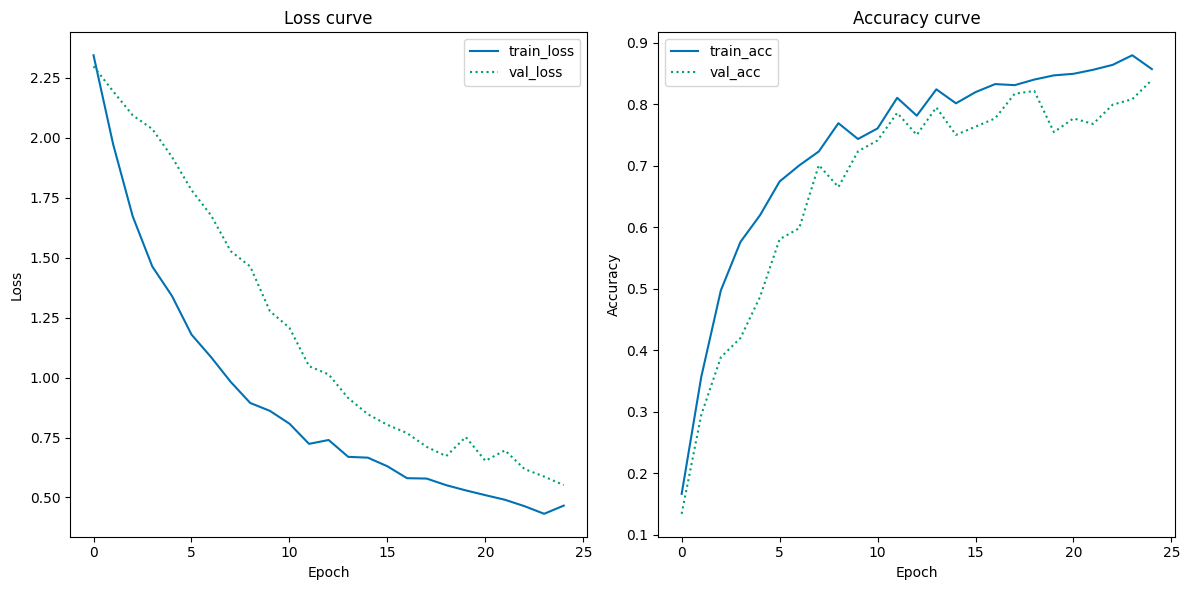

In [24]:
plot_history(H, 25)

Still more epochs would help but does seem a bit better?

__Evaluate__

In [25]:
model.evaluate(test_images)

2023-05-20 00:29:23.909945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 30s 916ms/step - loss: 0.7026 - accuracy: 0.7776


[0.7026249766349792, 0.7775609493255615]

accuracy has vastly improved when evaluating the test images but what does that mean when below it has barely improved?

In [26]:
predictions = model.predict(test_images, batch_size=32)
print(classification_report(test_images.classes,
                            predictions.argmax(axis=1),
                            target_names=classes))

2023-05-20 00:29:57.597459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 30s 906ms/step
              precision    recall  f1-score   support

       Apple       0.10      0.08      0.09        89
      Banana       0.14      0.16      0.15       106
     avocado       0.08      0.09      0.08       105
      cherry       0.08      0.10      0.09       105
        kiwi       0.11      0.10      0.11       105
       mango       0.04      0.04      0.04       105
      orange       0.10      0.10      0.10        97
  pinenapple       0.12      0.12      0.12       105
strawberries       0.13      0.10      0.11       103
  watermelon       0.09      0.09      0.09       105

    accuracy                           0.10      1025
   macro avg       0.10      0.10      0.10      1025
weighted avg       0.10      0.10      0.10      1025



Have only increased the f1/accuracy by 2% by adding a hidden layer and minor data augmentation. Mango is the serious struggle, the rest seem to be doing "okay" comparatively. 

Have increased f1/accuracy by 5% by adding the batch normalization, adding one hidden layer and some minor data augmentation. Cats are the only category that is struggling. 